In [1]:
import pandas as pd
import numpy as np
import umap
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../input/train_folds.csv")
df['path'] = df['id'].apply(lambda x: f'../input/train/{x[0]}/{x[1]}/{x[2]}/{x}.npy')

In [3]:
df.head(3)

,id,target,file_path,fold,path
0,00000e74ad,1,input/train/0/0/0/00000e74ad.npy,2,../input/train/0/0/0/00000e74ad.npy
1,00001f4945,0,input/train/0/0/0/00001f4945.npy,1,../input/train/0/0/0/00001f4945.npy
2,0000661522,0,input/train/0/0/0/0000661522.npy,3,../input/train/0/0/0/0000661522.npy


In [4]:
from nnAudio.Spectrogram import CQT1992v2
import torch
wave_transform = CQT1992v2(sr=2048, fmin=20, fmax=512, hop_length=16)

CQT kernels created, time used = 0.0385 seconds


/home/hamsh/anaconda3/envs/rapids-v4/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


In [5]:
# X_0 = []

# for _, d in tqdm(df.iterrows()):
#     a = np.load(d.path)
#     if d.target == 0:
#         X_0.append(a[0])

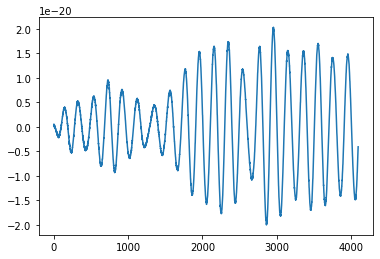

In [6]:
bh = np.load("../input/train/f/f/f/fffdf87619.npy")

plt.plot(bh[0])

In [7]:
import scipy

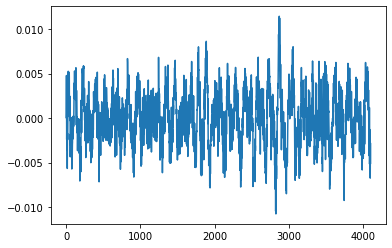

In [8]:
bHp, aHp = scipy.signal.butter(8, (20, 512), btype="bandpass", fs=2048)
plt.plot(scipy.signal.lfilter(bHp, aHp, bh[0]/5e-20))

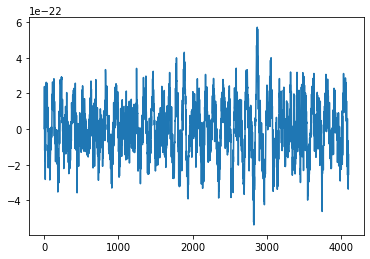

In [9]:
plt.plot(scipy.signal.lfilter(bHp, aHp, bh[0]))

CQT kernels created, time used = 0.0165 seconds


/home/hamsh/anaconda3/envs/rapids-v4/lib/python3.8/site-packages/nnAudio/utils.py:326: SyntaxWarning: If fmax is given, n_bins will be ignored
  warnings.warn('If fmax is given, n_bins will be ignored',SyntaxWarning)


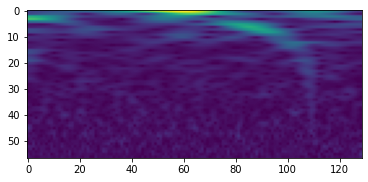

In [10]:
wave_transform = CQT1992v2(sr=2048, fmin=20, fmax=512, hop_length=32)
bHp, aHp = scipy.signal.butter(8, (20, 512), btype="bandpass", fs=2048)

ws = wave_transform(torch.from_numpy(scipy.signal.lfilter(bHp, aHp, bh[0])).float())
plt.imshow((ws).squeeze(0))

torch.Size([1, 57, 129])


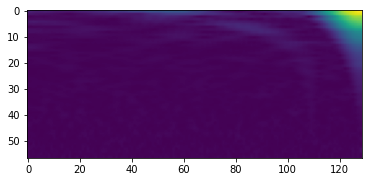

In [11]:
ws = wave_transform(torch.from_numpy(bh[0]).float())

print(ws.shape)
plt.imshow((ws).squeeze(0))

In [13]:
import numpy as np
import pandas as pd
import pywt
import torch
import torch.nn as nn
from scipy import signal
from scipy import optimize
import matplotlib.pyplot as plt
from pathlib import Path

In [14]:
# From https://github.com/tomrunia/PyTorchWavelets/blob/master/wavelets_pytorch/wavelets.py
class Morlet(object):
    def __init__(self, w0=6):
        """w0 is the nondimensional frequency constant. If this is
        set too low then the wavelet does not sample very well: a
        value over 5 should be ok; Terrence and Compo set it to 6.
        """
        self.w0 = w0
        if w0 == 6:
            # value of C_d from TC98
            self.C_d = 0.776

    def __call__(self, *args, **kwargs):
        return self.time(*args, **kwargs)

    def time(self, t, s=1.0, complete=True):
        """
        Complex Morlet wavelet, centred at zero.
        Parameters
        ----------
        t : float
            Time. If s is not specified, this can be used as the
            non-dimensional time t/s.
        s : float
            Scaling factor. Default is 1.
        complete : bool
            Whether to use the complete or the standard version.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given time
        See Also
        --------
        scipy.signal.gausspulse
        Notes
        -----
        The standard version::
            pi**-0.25 * exp(1j*w*x) * exp(-0.5*(x**2))
        This commonly used wavelet is often referred to simply as the
        Morlet wavelet.  Note that this simplified version can cause
        admissibility problems at low values of `w`.
        The complete version::
            pi**-0.25 * (exp(1j*w*x) - exp(-0.5*(w**2))) * exp(-0.5*(x**2))
        The complete version of the Morlet wavelet, with a correction
        term to improve admissibility. For `w` greater than 5, the
        correction term is negligible.
        Note that the energy of the return wavelet is not normalised
        according to `s`.
        The fundamental frequency of this wavelet in Hz is given
        by ``f = 2*s*w*r / M`` where r is the sampling rate.
        """
        w = self.w0

        x = t / s

        output = np.exp(1j * w * x)

        if complete:
            output -= np.exp(-0.5 * (w ** 2))

        output *= np.exp(-0.5 * (x ** 2)) * np.pi ** (-0.25)

        return output

    # Fourier wavelengths
    def fourier_period(self, s):
        """Equivalent Fourier period of Morlet"""
        return 4 * np.pi * s / (self.w0 + (2 + self.w0 ** 2) ** 0.5)

    def scale_from_period(self, period):
        """
        Compute the scale from the fourier period.
        Returns the scale
        """
        # Solve 4 * np.pi * scale / (w0 + (2 + w0 ** 2) ** .5)
        #  for s to obtain this formula
        coeff = np.sqrt(self.w0 * self.w0 + 2)
        return (period * (coeff + self.w0)) / (4.0 * np.pi)

    # Frequency representation
    def frequency(self, w, s=1.0):
        """Frequency representation of Morlet.
        Parameters
        ----------
        w : float
            Angular frequency. If `s` is not specified, i.e. set to 1,
            this can be used as the non-dimensional angular
            frequency w * s.
        s : float
            Scaling factor. Default is 1.
        Returns
        -------
        out : complex
            Value of the Morlet wavelet at the given frequency
        """
        x = w * s
        # Heaviside mock
        Hw = np.array(w)
        Hw[w <= 0] = 0
        Hw[w > 0] = 1
        return np.pi ** -0.25 * Hw * np.exp((-((x - self.w0) ** 2)) / 2)

    def coi(self, s):
        """The e folding time for the autocorrelation of wavelet
        power at each scale, i.e. the timescale over which an edge
        effect decays by a factor of 1/e^2.
        This can be worked out analytically by solving
            |Y_0(T)|^2 / |Y_0(0)|^2 = 1 / e^2
        """
        return 2 ** 0.5 * s


class CWT(nn.Module):
    def __init__(
        self,
        dj=0.0625,
        dt=1 / 2048,
        fmin: int = 20,
        fmax: int = 500,
        output_format="Magnitude",
        trainable=False,
    ):
        super().__init__()
        self.wavelet = Morlet()

        self.dt = dt
        self.dj = dj
        self.fmin = fmin
        self.fmax = fmax
        self.output_format = output_format
        self.trainable = trainable  # TODO make kernel a trainable parameter
        self.stride = (1, 1)  # Strides > 1 not yet supported

        self._scale_minimum = self.compute_minimum_scale()

        self.signal_length = None
        self._channels = None

        self._scales = None
        self._kernel = None
        self._kernel_real = None
        self._kernel_imag = None

    def compute_optimal_scales(self):
        """
        Determines the optimal scale distribution (see. Torrence & Combo, Eq. 9-10).
        :return: np.ndarray, collection of scales
        """
        if self.signal_length is None:
            raise ValueError(
                "Please specify signal_length before computing optimal scales."
            )
        J = int(
            (1 / self.dj) * np.log2(self.signal_length * self.dt / self._scale_minimum)
        )
        scales = self._scale_minimum * 2 ** (self.dj * np.arange(0, J + 1))

        # Remove high and low frequencies
        frequencies = np.array([1 / self.wavelet.fourier_period(s) for s in scales])
        if self.fmin:
            frequencies = frequencies[frequencies >= self.fmin]
            scales = scales[0 : len(frequencies)]
        if self.fmax:
            frequencies = frequencies[frequencies <= self.fmax]
            scales = scales[len(scales) - len(frequencies) : len(scales)]

        return scales

    def compute_minimum_scale(self):
        """
        Choose s0 so that the equivalent Fourier period is 2 * dt.
        See Torrence & Combo Sections 3f and 3h.
        :return: float, minimum scale level
        """
        dt = self.dt

        def func_to_solve(s):
            return self.wavelet.fourier_period(s) - 2 * dt

        return optimize.fsolve(func_to_solve, 1)[0]

    def _build_filters(self):
        self._filters = []
        for scale_idx, scale in enumerate(self._scales):
            # Number of points needed to capture wavelet
            M = 10 * scale / self.dt
            # Times to use, centred at zero
            t = torch.arange((-M + 1) / 2.0, (M + 1) / 2.0) * self.dt
            if len(t) % 2 == 0:
                t = t[0:-1]  # requires odd filter size
            # Sample wavelet and normalise
            norm = (self.dt / scale) ** 0.5
            filter_ = norm * self.wavelet(t, scale)
            self._filters.append(torch.conj(torch.flip(filter_, [-1])))

        self._pad_filters()

    def _pad_filters(self):
        filter_len = self._filters[-1].shape[0]
        padded_filters = []

        for f in self._filters:
            pad = (filter_len - f.shape[0]) // 2
            padded_filters.append(nn.functional.pad(f, (pad, pad)))

        self._filters = padded_filters

    def _build_wavelet_bank(self):
        """This function builds a 2D wavelet filter using wavelets at different scales

        Returns:
            tensor: Tensor of shape (num_widths, 1, channels, filter_len)
        """
        self._build_filters()
        wavelet_bank = torch.stack(self._filters)
        wavelet_bank = wavelet_bank.view(
            wavelet_bank.shape[0], 1, 1, wavelet_bank.shape[1]
        )
        wavelet_bank = torch.cat([wavelet_bank] * self.channels, 2)
        return wavelet_bank

    def forward(self, x):
        """Compute CWT arrays from a batch of multi-channel inputs

        Args:
            x (torch.tensor): Tensor of shape (batch_size, channels, time)

        Returns:
            torch.tensor: Tensor of shape (batch_size, channels, widths, time)
        """
        if self.signal_length is None:
            self.signal_length = x.shape[-1]
            self.channels = x.shape[-2]
            self._scales = self.compute_optimal_scales()
            self._kernel = self._build_wavelet_bank()

            if self._kernel.is_complex():
                self._kernel_real = self._kernel.real
                self._kernel_imag = self._kernel.imag

        x = x.unsqueeze(1)

        if self._kernel.is_complex():
            if (
                x.dtype != self._kernel_real.dtype
                or x.device != self._kernel_real.device
            ):
                self._kernel_real = self._kernel_real.to(device=x.device, dtype=x.dtype)
                self._kernel_imag = self._kernel_imag.to(device=x.device, dtype=x.dtype)

            output_real = nn.functional.conv2d(
                x, self._kernel_real, padding="same", stride=self.stride
            )
            output_imag = nn.functional.conv2d(
                x, self._kernel_imag, padding="same", stride=self.stride
            )
            output_real = torch.transpose(output_real, 1, 2)
            output_imag = torch.transpose(output_imag, 1, 2)

            if self.output_format == "Magnitude":
                return torch.sqrt(output_real ** 2 + output_imag ** 2)
            else:
                return torch.stack([output_real, output_imag], -1)

        else:
            if x.device != self._kernel.device:
                self._kernel = self._kernel.to(device=x.device, dtype=x.dtype)

            output = nn.functional.conv2d(
                x, self._kernel, padding="same", stride=self.stride
            )
            return torch.transpose(output, 1, 2)

In [15]:
pycwt = CWT(fmin=20, fmax=512)

In [18]:
out = pycwt(torch.from_numpy(bh[0]).float()/5e-20)

plt.imshow(out.numpy())

AttributeError: 'NoneType' object has no attribute 'is_complex'